In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Matplotlib/Seaborn imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Plotly imports
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.colors import qualitative, sequential, diverging
import plotly.offline as pyo

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Plotly configuration
PLOTLY_THEME = "plotly_white"
PLOTLY_COLOR_SEQUENCE = px.colors.qualitative.Set2

In [2]:
class CriterionAnalyzer:
    def __init__(self, json_file: str, theme: str = "default"):
        """
        Focused Criterion Benchmark Analyzer with separate plot functions.
        
        Args:
            json_file: Path to criterion JSON output
            theme: Visual theme ('default', 'dark', 'minimal', 'publication')
        """
        self.json_file = Path(json_file)
        self.theme = theme
        self.raw_data = self._load_raw_data()
        self.samples_df = self._parse_raw_samples()
        self.summary_df = self._calculate_summary_stats()
        self.comparisons_df = self._calculate_pairwise_comparisons()
        
        # Configure themes
        self._configure_themes()
        
        # Color schemes
        self.mpl_colors = ['#2E8B57', '#FF6B35', '#4ECDC4', '#9B59B6', '#E74C3C', '#F39C12', '#34495E']
        self.plotly_colors = PLOTLY_COLOR_SEQUENCE
        
        if not self.samples_df.empty:
            print(f"✅ Loaded {len(self.samples_df)} samples from {len(self.raw_data)} benchmarks")
            print(f"📊 Groups: {list(self.samples_df['group'].unique())}")
            print(f"🔧 Functions: {list(self.samples_df['function'].unique())}")
        
    def _configure_themes(self):
        """Configure visual themes."""
        if self.theme == "dark":
            plt.style.use('dark_background')
            self.plotly_template = "plotly_dark"
            self.mpl_colors = ['#00D4AA', '#FF6B6B', '#4ECDC4', '#A8E6CF', '#FFD93D', '#6BCF7F']
        elif self.theme == "minimal":
            plt.style.use('seaborn-v0_8-whitegrid')
            self.plotly_template = "simple_white"
        elif self.theme == "publication":
            plt.style.use('seaborn-v0_8-paper')
            self.plotly_template = "none"
            self.mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        else:
            self.plotly_template = PLOTLY_THEME

    def _load_raw_data(self) -> List[Dict]:
        """Load and parse JSON lines from criterion output."""
        data = []
        try:
            with open(self.json_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line and line.startswith('{'):
                        try:
                            record = json.loads(line)
                            if record.get('reason') == 'benchmark-complete':
                                data.append(record)
                        except json.JSONDecodeError:
                            continue
        except FileNotFoundError:
            print(f"❌ Error: File {self.json_file} not found!")
            return []
        
        return data
        
    def _parse_raw_samples(self) -> pd.DataFrame:
        """Parse raw measurement data into sample-level DataFrame."""
        all_samples = []
        
        for record in self.raw_data:
            benchmark_id = record['id']
            
            if '/' in benchmark_id:
                group, function = benchmark_id.split('/', 1)
            else:
                group = 'Unknown'
                function = benchmark_id
            
            iteration_counts = record.get('iteration_count', [])
            measured_values = record.get('measured_values', [])
            
            for i, (iters, total_time_ns) in enumerate(zip(iteration_counts, measured_values)):
                if iters > 0:
                    time_per_iter_ns = total_time_ns / iters
                    time_per_iter_ms = time_per_iter_ns / 1_000_000
                    time_per_iter_us = time_per_iter_ns / 1_000
                    
                    sample = {
                        'group': group,
                        'function': function,
                        'benchmark_id': benchmark_id,
                        'sample_index': i,
                        'iteration_count': iters,
                        'total_time_ns': total_time_ns,
                        'time_per_iter_ns': time_per_iter_ns,
                        'time_per_iter_ms': time_per_iter_ms,
                        'time_per_iter_us': time_per_iter_us,
                        'throughput_per_sec': 1_000_000_000 / time_per_iter_ns,
                        'efficiency_score': 1 / time_per_iter_ns,
                    }
                    all_samples.append(sample)
        
        if not all_samples:
            return pd.DataFrame()
        
        df = pd.DataFrame(all_samples)
        
        # Add derived metrics
        df['log_time_ns'] = np.log10(df['time_per_iter_ns'])
        df['normalized_time'] = df.groupby('group')['time_per_iter_ns'].transform(
            lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
        )
        
        return df
    
    def _calculate_summary_stats(self) -> pd.DataFrame:
        """Calculate comprehensive summary statistics."""
        if self.samples_df.empty:
            return pd.DataFrame()
        
        summary_stats = []
        
        for group in self.samples_df['group'].unique():
            group_data = self.samples_df[self.samples_df['group'] == group]
            
            for function in group_data['function'].unique():
                func_data = group_data[group_data['function'] == function]
                times_ns = func_data['time_per_iter_ns'].values
                
                # Basic statistics
                mean_ns = np.mean(times_ns)
                median_ns = np.median(times_ns)
                std_ns = np.std(times_ns, ddof=1)
                sem_ns = stats.sem(times_ns)
                
                # Confidence intervals
                ci_95 = stats.t.interval(0.95, len(times_ns)-1, loc=mean_ns, scale=sem_ns)
                
                # Percentiles
                percentiles = np.percentile(times_ns, [5, 25, 75, 95])
                
                # Advanced statistics
                cv = (std_ns / mean_ns) * 100
                
                # Outlier detection
                q1, q3 = np.percentile(times_ns, [25, 75])
                iqr = q3 - q1
                outlier_bounds = [q1 - 1.5*iqr, q3 + 1.5*iqr]
                outliers = times_ns[(times_ns < outlier_bounds[0]) | (times_ns > outlier_bounds[1])]
                
                summary = {
                    'group': group,
                    'function': function,
                    'sample_count': len(func_data),
                    'mean_ns': mean_ns,
                    'mean_ms': mean_ns / 1_000_000,
                    'median_ns': median_ns,
                    'median_ms': median_ns / 1_000_000,
                    'std_ns': std_ns,
                    'std_ms': std_ns / 1_000_000,
                    'sem_ns': sem_ns,
                    'sem_ms': sem_ns / 1_000_000,
                    'ci95_lower_ns': ci_95[0],
                    'ci95_upper_ns': ci_95[1],
                    'ci95_lower_ms': ci_95[0] / 1_000_000,
                    'ci95_upper_ms': ci_95[1] / 1_000_000,
                    'ci95_width_ms': (ci_95[1] - ci_95[0]) / 1_000_000,
                    'p05_ns': percentiles[0], 'p25_ns': percentiles[1],
                    'p75_ns': percentiles[2], 'p95_ns': percentiles[3],
                    'p05_ms': percentiles[0] / 1_000_000, 'p25_ms': percentiles[1] / 1_000_000,
                    'p75_ms': percentiles[2] / 1_000_000, 'p95_ms': percentiles[3] / 1_000_000,
                    'cv_percent': cv,
                    'outlier_count': len(outliers),
                    'outlier_percentage': (len(outliers) / len(times_ns)) * 100,
                    'throughput_per_sec': 1_000_000_000 / mean_ns,
                    'stability_score': 100 - cv,
                }
                summary_stats.append(summary)
        
        return pd.DataFrame(summary_stats)
    
    def _calculate_pairwise_comparisons(self) -> pd.DataFrame:
        """Calculate pairwise statistical comparisons."""
        if self.samples_df.empty:
            return pd.DataFrame()
            
        comparisons = []
        
        for group in self.samples_df['group'].unique():
            group_samples = self.samples_df[self.samples_df['group'] == group]
            functions = group_samples['function'].unique()
            
            for i, func1 in enumerate(functions):
                for j, func2 in enumerate(functions):
                    if i >= j:
                        continue
                    
                    samples1 = group_samples[group_samples['function'] == func1]['time_per_iter_ns'].values
                    samples2 = group_samples[group_samples['function'] == func2]['time_per_iter_ns'].values
                    
                    # Statistical tests
                    t_stat, p_value = stats.ttest_ind(samples1, samples2, equal_var=False)
                    
                    # Effect size
                    pooled_std = np.sqrt(((len(samples1)-1)*np.var(samples1, ddof=1) + 
                                        (len(samples2)-1)*np.var(samples2, ddof=1)) / 
                                       (len(samples1) + len(samples2) - 2))
                    cohens_d = abs(np.mean(samples1) - np.mean(samples2)) / pooled_std
                    
                    # Practical significance
                    mean_diff_ms = abs(np.mean(samples1) - np.mean(samples2)) / 1_000_000
                    percent_diff = abs(np.mean(samples1) - np.mean(samples2)) / min(np.mean(samples1), np.mean(samples2)) * 100
                    
                    comparison = {
                        'group': group,
                        'function1': func1,
                        'function2': func2,
                        'comparison': f"{func1} vs {func2}",
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'cohens_d': cohens_d,
                        'mean_diff_ms': mean_diff_ms,
                        'percent_diff': percent_diff,
                        'significant': p_value < 0.05,
                        'effect_size_category': self._categorize_effect_size(cohens_d),
                    }
                    comparisons.append(comparison)
        
        return pd.DataFrame(comparisons)
    
    def _categorize_effect_size(self, cohens_d: float) -> str:
        """Categorize Cohen's d effect size."""
        if cohens_d < 0.2:
            return "Negligible"
        elif cohens_d < 0.5:
            return "Small"
        elif cohens_d < 0.8:
            return "Medium"
        else:
            return "Large"

    def print_summary(self):
        """Print comprehensive benchmark summary."""
        if self.summary_df.empty:
            print("❌ No benchmark data to summarize!")
            return
            
        print("\n" + "="*80)
        print("📊 CRITERION BENCHMARK ANALYSIS SUMMARY")
        print("="*80)
        
        for group in self.summary_df['group'].unique():
            group_data = self.summary_df[self.summary_df['group'] == group]
            print(f"\n🔹 {group}:")
            print("-" * (len(group) + 3))
            
            for _, row in group_data.iterrows():
                ci_width = row['ci95_width_ms'] / 2
                print(f"  {row['function']:<12}: {row['mean_ms']:.4f} ms ± {ci_width:.4f} ms "
                      f"(n={row['sample_count']}, CV={row['cv_percent']:.1f}%)")
            
            # Relative performance
            if len(group_data) > 1:
                fastest = group_data.loc[group_data['mean_ms'].idxmin()]
                print(f"\n  📈 Relative to {fastest['function']} (fastest):")
                for _, row in group_data.iterrows():
                    if row['function'] != fastest['function']:
                        slowdown = row['mean_ms'] / fastest['mean_ms']
                        print(f"    {row['function']}: {slowdown:.2f}x slower")
        
        # Statistical comparisons
        if not self.comparisons_df.empty:
            print(f"\n📊 Statistical Significance:")
            print("-" * 25)
            curr_group = ""
            for _, comp in self.comparisons_df.iterrows():
                if comp['group'] != curr_group:
                    print(comp["group"])
                curr_group = comp["group"]
                sig_marker = "***" if comp['p_value'] < 0.001 else "**" if comp['p_value'] < 0.01 else "*" if comp['significant'] else "ns"
                print(f"  {comp['comparison']}: {comp['mean_diff_ms']:.4f}ms diff, "
                      f"p={comp['p_value']:.6f} {sig_marker}, effect: {comp['effect_size_category']}")

    # ==================== MATPLOTLIB PLOTS ====================
    
    def plot_performance_comparison(self, save_path: Optional[str] = None):
        """Clean performance comparison with confidence intervals."""
        if self.summary_df.empty:
            return
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Group data for plotting
        x_positions = []
        means = []
        errors = []
        colors = []
        labels = []
        
        x_pos = 0
        group_positions = {}
        
        for group in self.summary_df['group'].unique():
            group_data = self.summary_df[self.summary_df['group'] == group]
            group_positions[group] = []
            
            for i, (_, row) in enumerate(group_data.iterrows()):
                x_positions.append(x_pos)
                means.append(row['mean_ms'])
                errors.append(row['ci95_width_ms'] / 2)
                colors.append(self.mpl_colors[i % len(self.mpl_colors)])
                labels.append(f"{group}\n{row['function']}")
                group_positions[group].append(x_pos)
                x_pos += 1
            
            x_pos += 0.5  # Space between groups
        
        # Create bars
        bars = ax.bar(x_positions, means, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add error bars
        ax.errorbar(x_positions, means, yerr=errors, fmt='none', ecolor='black', capsize=5, capthick=2)
        
        # Add value labels
        for bar, mean_val, error in zip(bars, means, errors):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error + max(means)*0.02,
                   f'{mean_val:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Customize plot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_ylabel('Execution Time (ms)', fontsize=14, fontweight='bold')
        ax.set_title('Performance Comparison with 95% Confidence Intervals', fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add group separators
        for group, positions in group_positions.items():
            if len(positions) > 1:
                start = min(positions) - 0.4
                end = max(positions) + 0.4
                ax.axvspan(start, end, alpha=0.1, color='gray')
                ax.text((start + end) / 2, max(means) * 1.15, group, 
                       ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_distribution_analysis(self, save_path: Optional[str] = None):
        """Distribution analysis with violin plots."""
        if self.samples_df.empty:
            return
        
        # Calculate number of subplots needed
        groups = self.samples_df['group'].unique()
        n_groups = len(groups)
        
        fig, axes = plt.subplots(1, n_groups, figsize=(6*n_groups, 8))
        if n_groups == 1:
            axes = [axes]
        
        for i, group in enumerate(groups):
            group_data = self.samples_df[self.samples_df['group'] == group]
            functions = group_data['function'].unique()
            
            # Prepare data for violin plot
            data_for_violin = []
            labels_for_violin = []
            
            for function in functions:
                func_data = group_data[group_data['function'] == function]
                data_for_violin.append(func_data['time_per_iter_ms'].values)
                labels_for_violin.append(function)
            
            # Create violin plot
            parts = axes[i].violinplot(data_for_violin, positions=range(len(functions)), 
                                     widths=0.8, showmeans=True, showextrema=True, showmedians=True)
            
            # Color the violins
            for j, pc in enumerate(parts['bodies']):
                pc.set_facecolor(self.mpl_colors[j % len(self.mpl_colors)])
                pc.set_alpha(0.7)
            
            # Customize subplot
            axes[i].set_xticks(range(len(functions)))
            axes[i].set_xticklabels(labels_for_violin, rotation=45)
            axes[i].set_ylabel('Time per Iteration (ms)' if i == 0 else '')
            axes[i].set_title(f'{group}\nDistribution Analysis', fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            # Add summary statistics as text
            for j, function in enumerate(functions):
                func_summary = self.summary_df[
                    (self.summary_df['group'] == group) & 
                    (self.summary_df['function'] == function)
                ].iloc[0]
                
                axes[i].text(j, max([max(d) for d in data_for_violin]) * 1.05,
                           f'μ={func_summary["mean_ms"]:.4f}\nσ={func_summary["std_ms"]:.4f}',
                           ha='center', va='bottom', fontsize=9,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_stability_analysis(self, save_path: Optional[str] = None):
        """Stability analysis over sample index."""
        if self.samples_df.empty:
            return
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        for i, group in enumerate(self.samples_df['group'].unique()):
            group_samples = self.samples_df[self.samples_df['group'] == group]
            
            for j, function in enumerate(group_samples['function'].unique()):
                func_data = group_samples[group_samples['function'] == function].sort_values('sample_index')
                
                # Plot raw samples
                ax.plot(func_data['sample_index'], func_data['time_per_iter_ms'], 
                       'o-', alpha=0.6, color=self.mpl_colors[j % len(self.mpl_colors)], 
                       label=f"{group}-{function}", markersize=4, linewidth=1)
                
                # Add rolling mean
                window_size = min(20, len(func_data) // 3)
                if window_size > 5:
                    rolling_mean = func_data['time_per_iter_ms'].rolling(window=window_size, center=True).mean()
                    ax.plot(func_data['sample_index'], rolling_mean, 
                           color=self.mpl_colors[j % len(self.mpl_colors)], linewidth=3, alpha=0.9,
                           linestyle='--')
        
        ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
        ax.set_ylabel('Time per Iteration (ms)', fontsize=12, fontweight='bold')
        ax.set_title('Performance Stability Over Time\n(Solid lines: raw samples, Dashed lines: rolling average)', 
                    fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    # ==================== PLOTLY INTERACTIVE PLOTS ====================
    
    def plot_interactive_comparison(self, save_html: Optional[str] = None):
        """Interactive performance comparison with Plotly."""
        if self.summary_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.summary_df['group'].unique()):
            group_data = self.summary_df[self.summary_df['group'] == group]
            
            fig.add_trace(
                go.Bar(
                    x=group_data['function'],
                    y=group_data['mean_ms'],
                    error_y=dict(
                        type='data',
                        array=group_data['ci95_width_ms'] / 2,
                        visible=True
                    ),
                    name=group,
                    marker_color=self.plotly_colors[i % len(self.plotly_colors)],
                    hovertemplate="<b>%{fullData.name} - %{x}</b><br>" +
                                "Mean: %{y:.4f} ms<br>" +
                                "Samples: %{customdata[0]}<br>" +
                                "CV: %{customdata[1]:.1f}%<br>" +
                                "95% CI: ±%{error_y.array:.4f} ms<br>" +
                                "Stability Score: %{customdata[2]:.1f}/100<br>" +
                                "Throughput: %{customdata[3]:.0f}/sec<br>" +
                                "<extra></extra>",
                    customdata=np.column_stack((
                        group_data['sample_count'], 
                        group_data['cv_percent'],
                        group_data['stability_score'],
                        group_data['throughput_per_sec']
                    ))
                )
            )
        
        fig.update_layout(
            title=dict(
                text="🚀 Interactive Performance Comparison",
                font=dict(size=20),
                x=0.5
            ),
            xaxis_title="Implementation",
            yaxis_title="Execution Time (ms)",
            template=self.plotly_template,
            hovermode='closest',
            showlegend=True,
            height=600,
            updatemenus=[
                dict(
                    type="buttons",
                    direction="left",
                    buttons=list([
                        dict(
                            args=[{"yaxis.type": "linear"}],
                            label="Linear Scale",
                            method="relayout"
                        ),
                        dict(
                            args=[{"yaxis.type": "log"}],
                            label="Log Scale",
                            method="relayout"
                        )
                    ]),
                    pad={"r": 10, "t": 10},
                    showactive=True,
                    x=0.01,
                    xanchor="left",
                    y=1.15,
                    yanchor="top"
                ),
            ]
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"💾 Interactive comparison saved to {save_html}")
        return fig
    
    def plot_interactive_distributions(self, save_html: Optional[str] = None):
        """Interactive distribution analysis."""
        if self.samples_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.samples_df['group'].unique()):
            group_samples = self.samples_df[self.samples_df['group'] == group]
            
            for j, function in enumerate(group_samples['function'].unique()):
                func_data = group_samples[group_samples['function'] == function]
                
                fig.add_trace(
                    go.Violin(
                        y=func_data['time_per_iter_ms'],
                        name=f"{group} - {function}",
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor=self.plotly_colors[j % len(self.plotly_colors)],
                        opacity=0.7,
                        side='positive',
                        hovertemplate="<b>%{fullData.name}</b><br>" +
                                    "Value: %{y:.4f} ms<br>" +
                                    "Sample: %{pointNumber}<br>" +
                                    "<extra></extra>",
                        points='outliers',
                        pointpos=0,
                        jitter=0.05
                    )
                )
        
        fig.update_layout(
            title=dict(
                text="🎻 Interactive Distribution Analysis",
                font=dict(size=20),
                x=0.5
            ),
            yaxis_title="Time per Iteration (ms)",
            template=self.plotly_template,
            height=600,
            showlegend=True
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"🎻 Interactive distributions saved to {save_html}")
        return fig
    
    def plot_interactive_stability(self, save_html: Optional[str] = None):
        """Interactive stability timeline."""
        if self.samples_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.samples_df['group'].unique()):
            group_samples = self.samples_df[self.samples_df['group'] == group]
            
            for j, function in enumerate(group_samples['function'].unique()):
                func_data = group_samples[group_samples['function'] == function].sort_values('sample_index')
                
                # Raw samples
                fig.add_trace(
                    go.Scatter(
                        x=func_data['sample_index'],
                        y=func_data['time_per_iter_ms'],
                        mode='lines+markers',
                        name=f"{group} - {function}",
                        line=dict(color=self.plotly_colors[j % len(self.plotly_colors)], width=2),
                        marker=dict(size=6, opacity=0.7),
                        hovertemplate="<b>%{fullData.name}</b><br>" +
                                    "Sample: %{x}<br>" +
                                    "Time: %{y:.4f} ms<br>" +
                                    "Iterations: %{customdata[0]}<br>" +
                                    "Total Time: %{customdata[1]:.2f} ms<br>" +
                                    "<extra></extra>",
                        customdata=np.column_stack((
                            func_data['iteration_count'],
                            func_data['total_time_ns'] / 1_000_000
                        ))
                    )
                )
                
                # Rolling average
                window_size = min(20, len(func_data) // 3)
                if window_size > 5:
                    rolling_mean = func_data['time_per_iter_ms'].rolling(window=window_size, center=True).mean()
                    fig.add_trace(
                        go.Scatter(
                            x=func_data['sample_index'],
                            y=rolling_mean,
                            mode='lines',
                            name=f"{group} - {function} (Rolling Avg)",
                            line=dict(color=self.plotly_colors[j % len(self.plotly_colors)], width=4, dash='dash'),
                            opacity=0.8,
                            hovertemplate="<b>%{fullData.name}</b><br>" +
                                        "Sample: %{x}<br>" +
                                        "Rolling Mean: %{y:.4f} ms<br>" +
                                        f"Window: {window_size} samples<br>" +
                                        "<extra></extra>"
                        )
                    )
        
        fig.update_layout(
            title=dict(
                text="📈 Interactive Stability Analysis",
                font=dict(size=20),
                x=0.5
            ),
            xaxis_title="Sample Index",
            yaxis_title="Time per Iteration (ms)",
            template=self.plotly_template,
            height=600,
            showlegend=True,
            hovermode='x unified'
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"📈 Interactive stability saved to {save_html}")
        
        return fig
    
    def plot_performance_radar(self, save_html: Optional[str] = None):
        """Performance radar chart comparing multiple metrics."""
        if self.summary_df.empty:
            return
        
        fig = go.Figure()
        
        metrics = ['Speed', 'Stability', 'Consistency', 'Precision']
        
        for i, (_, row) in enumerate(self.summary_df.iterrows()):
            # Normalize metrics (0-100 scale)
            speed_score = 100 - ((row['mean_ms'] - self.summary_df['mean_ms'].min()) / 
                                (self.summary_df['mean_ms'].max() - self.summary_df['mean_ms'].min()) * 100)
            stability_score = row['stability_score']
            consistency_score = 100 - min(row['cv_percent'], 50)  # Cap at 50% for scaling
            precision_score = 100 - ((row['ci95_width_ms'] - self.summary_df['ci95_width_ms'].min()) / 
                                   (self.summary_df['ci95_width_ms'].max() - self.summary_df['ci95_width_ms'].min()) * 100)
            
            values = [speed_score, stability_score, consistency_score, precision_score]
            
            fig.add_trace(
                go.Scatterpolar(
                    r=values,
                    theta=metrics,
                    fill='toself',
                    name=f"{row['group']} - {row['function']}",
                    line_color=self.plotly_colors[i % len(self.plotly_colors)],
                    fillcolor=self.plotly_colors[i % len(self.plotly_colors)],
                    opacity=0.6,
                    hovertemplate="<b>%{fullData.name}</b><br>" +
                                "Metric: %{theta}<br>" +
                                "Score: %{r:.1f}/100<br>" +
                                "<extra></extra>"
                )
            )
        
        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 100]
                )
            ),
            title=dict(
                text="🎯 Performance Radar Chart",
                font=dict(size=20),
                x=0.5
            ),
            template=self.plotly_template,
            height=600,
            showlegend=True
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"🎯 Performance radar saved to {save_html}")
        
        return fig
    
    
    def export_all_plots(self, output_dir: str = "benchmark_plots"):
        """Export all plots as both static and interactive versions."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        
        print(f"📊 Exporting all plots to {output_path}/")
        
        # Matplotlib plots
        print("  🎨 Generating matplotlib plots...")
        self.plot_performance_comparison(output_path / "performance_comparison.png")
        self.plot_distribution_analysis(output_path / "distribution_analysis.png")
        self.plot_stability_analysis(output_path / "stability_analysis.png")
        
        # Plotly plots
        print("  ⚡ Generating interactive Plotly plots...")
        self.plot_interactive_comparison(output_path / "interactive_comparison.html")
        self.plot_interactive_distributions(output_path / "interactive_distributions.html")
        self.plot_interactive_stability(output_path / "interactive_stability.html")
        self.plot_performance_radar(output_path / "performance_radar.html")
        
        # Export data
        if not self.samples_df.empty:
            self.samples_df.to_csv(output_path / "raw_samples.csv", index=False)
        if not self.summary_df.empty:
            self.summary_df.to_csv(output_path / "summary_statistics.csv", index=False)
        if not self.comparisons_df.empty:
            self.comparisons_df.to_csv(output_path / "statistical_comparisons.csv", index=False)
        
        print(f"✅ All plots and data exported to {output_path}/")
        return output_path

In [3]:
# Voor snelle analyse
json_files = ["newresults.json", "wamrvswasmtime.json"]
json_selector = 0
json_file = json_files[json_selector]
theme = 'publication'#"default"
analyzer = CriterionAnalyzer(json_file, theme=theme)
analyzer.print_summary()

✅ Loaded 900 samples from 9 benchmarks
📊 Groups: ['Runtime Setup', 'Cold Ping Pong Execution', 'Hot Ping Pong Execution']
🔧 Functions: ['Native', 'WAMR', 'Wasmtime']

📊 CRITERION BENCHMARK ANALYSIS SUMMARY

🔹 Runtime Setup:
----------------
  Native      : 0.0019 ms ± 0.0000 ms (n=100, CV=0.5%)
  WAMR        : 0.2531 ms ± 0.0001 ms (n=100, CV=0.1%)
  Wasmtime    : 19.5592 ms ± 0.0023 ms (n=100, CV=0.1%)

  📈 Relative to Native (fastest):
    WAMR: 130.03x slower
    Wasmtime: 10048.10x slower

🔹 Cold Ping Pong Execution:
---------------------------
  Native      : 0.5945 ms ± 0.0001 ms (n=100, CV=0.0%)
  WAMR        : 1.2110 ms ± 0.0010 ms (n=100, CV=0.4%)
  Wasmtime    : 1.3019 ms ± 0.0010 ms (n=100, CV=0.4%)

  📈 Relative to Native (fastest):
    WAMR: 2.04x slower
    Wasmtime: 2.19x slower

🔹 Hot Ping Pong Execution:
--------------------------
  Native      : 0.5890 ms ± 0.0000 ms (n=100, CV=0.0%)
  WAMR        : 1.1855 ms ± 0.0001 ms (n=100, CV=0.1%)
  Wasmtime    : 1.1844 ms ± 0.

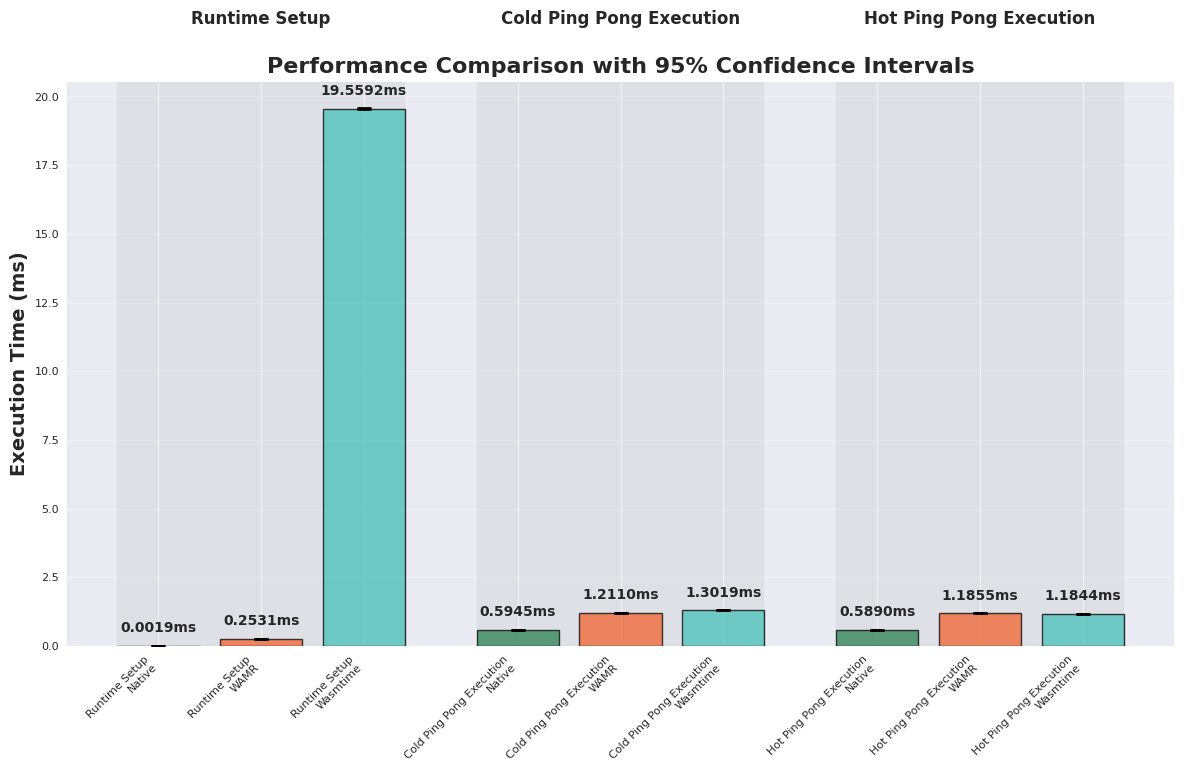

In [4]:
analyzer.plot_performance_comparison()

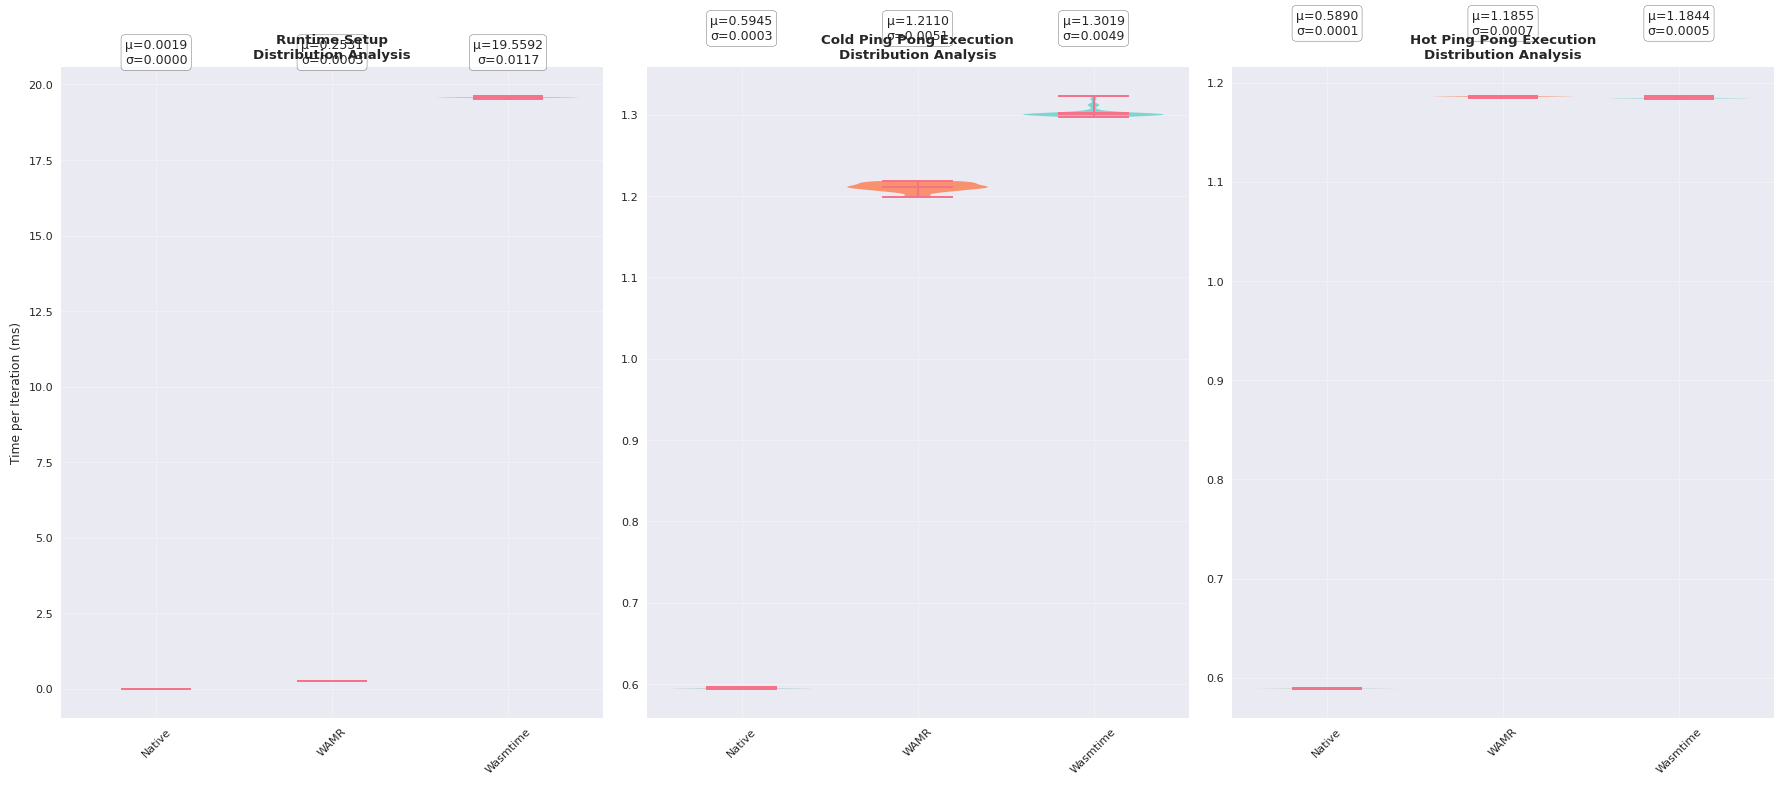

In [5]:
analyzer.plot_distribution_analysis()

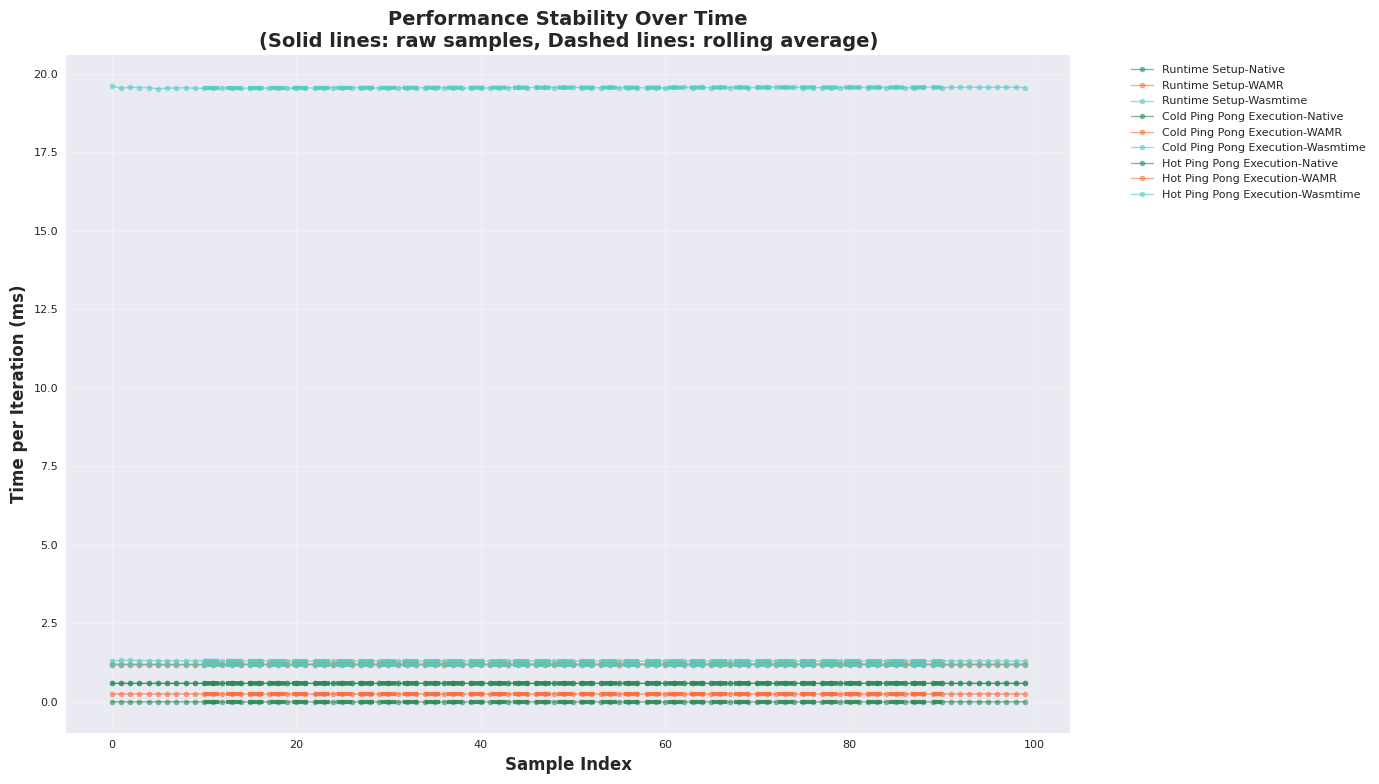

In [6]:
analyzer.plot_stability_analysis()

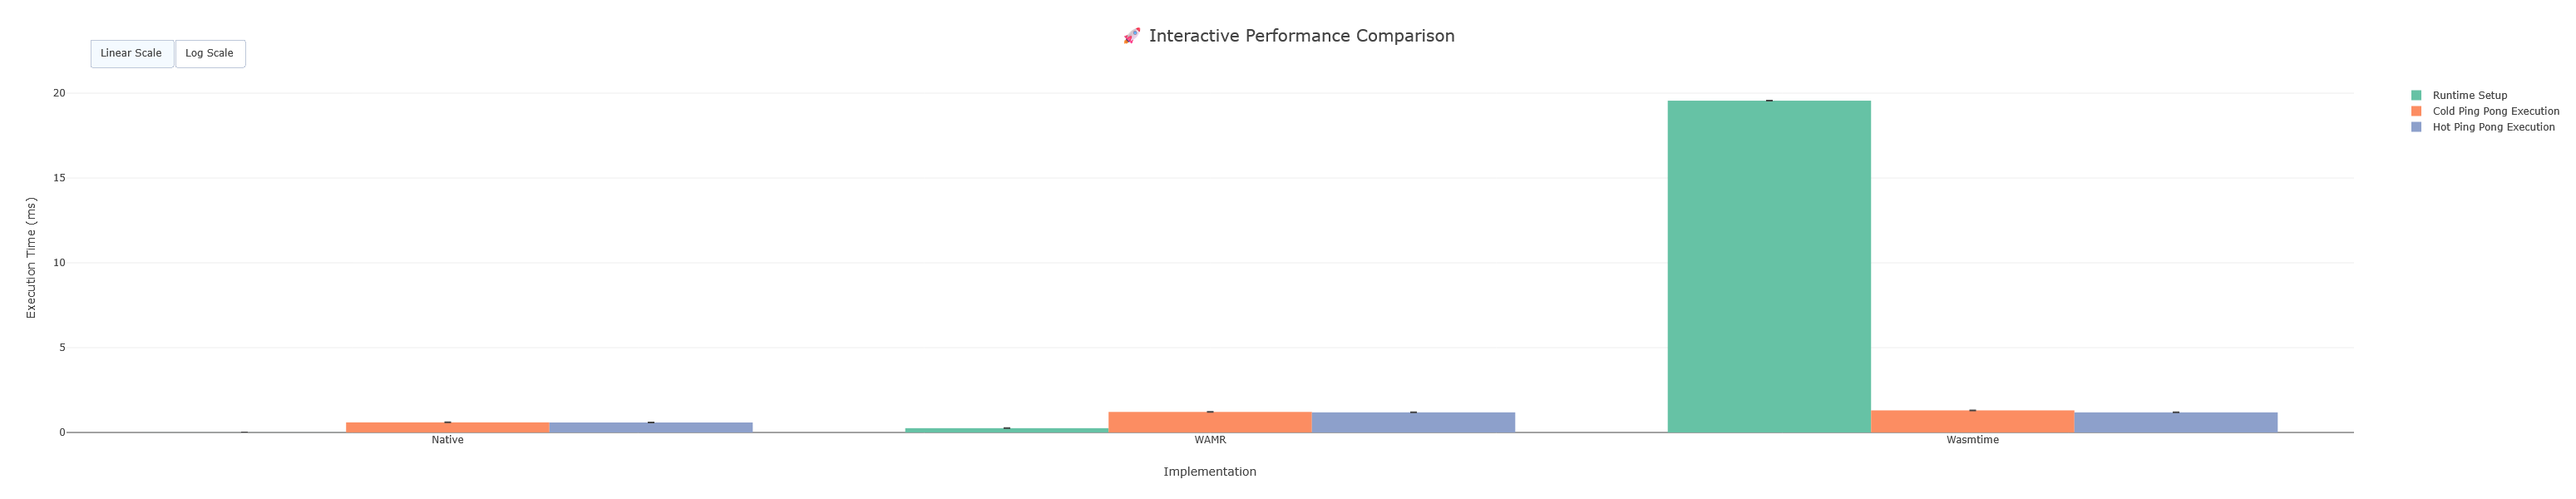

In [7]:
analyzer.plot_interactive_comparison()

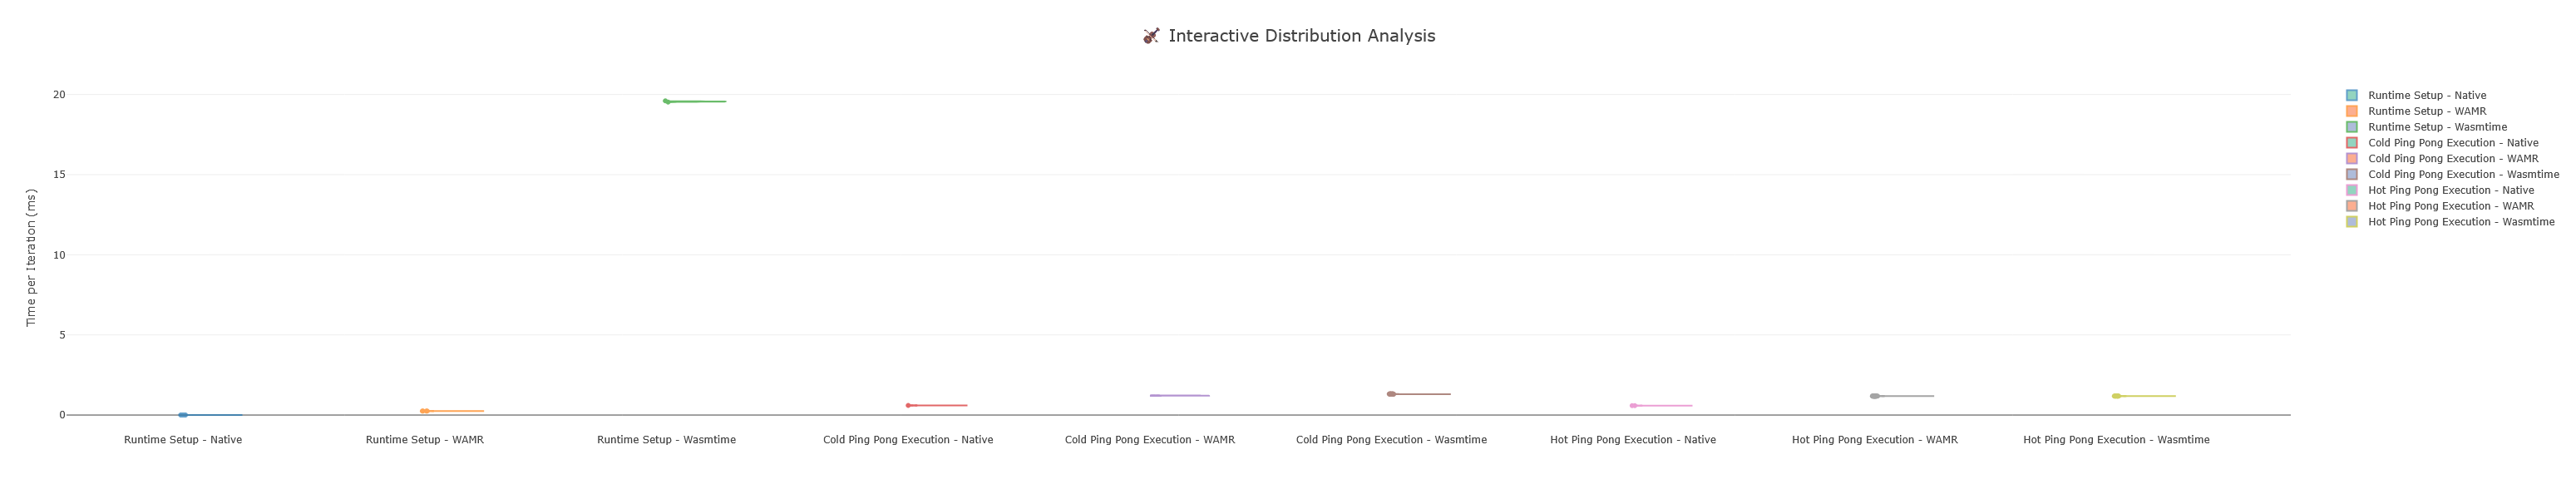

In [8]:
analyzer.plot_interactive_distributions()

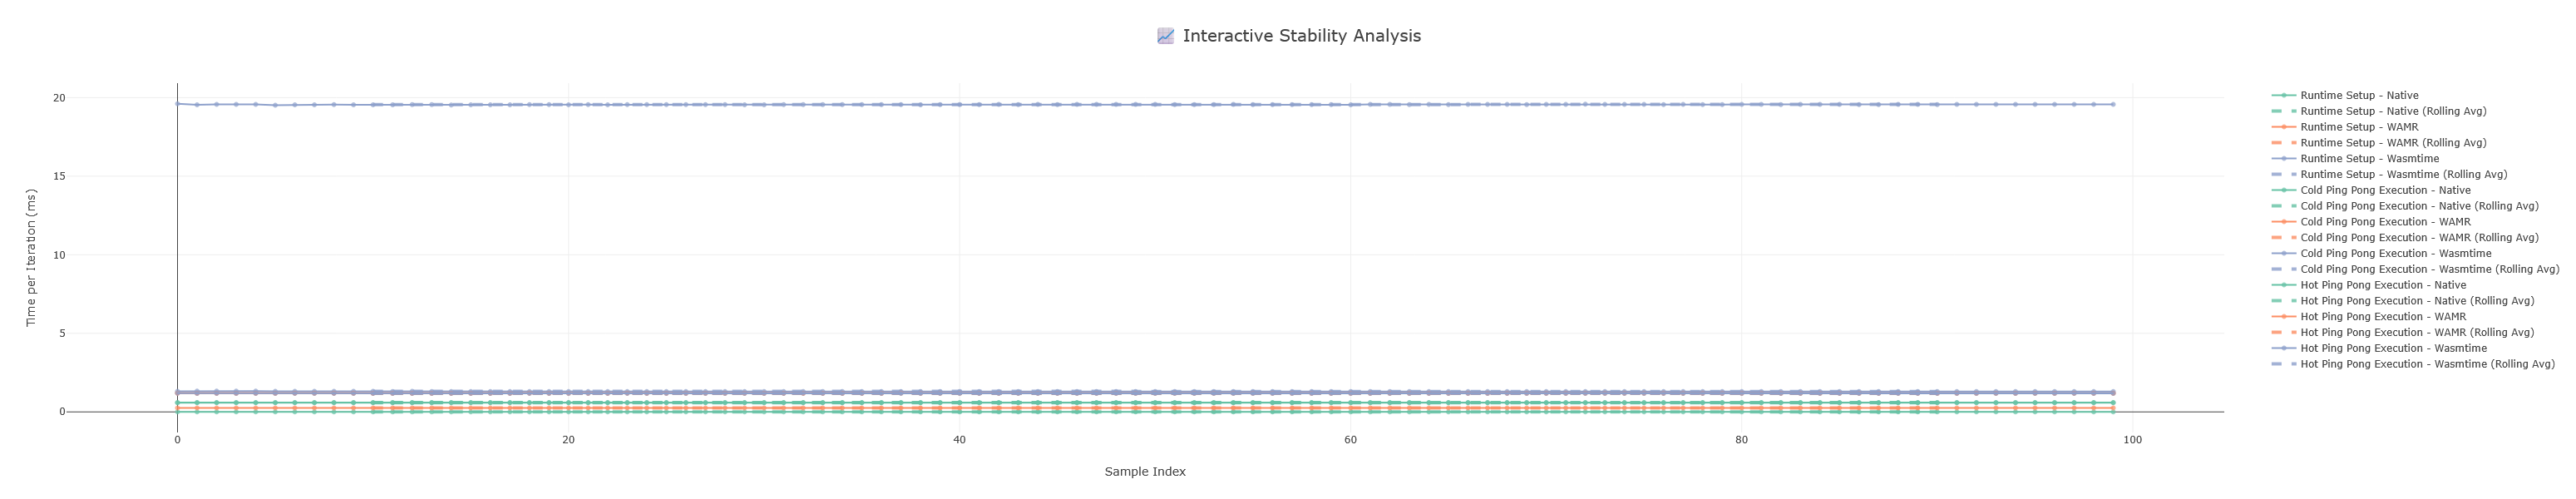

In [9]:
analyzer.plot_interactive_stability()

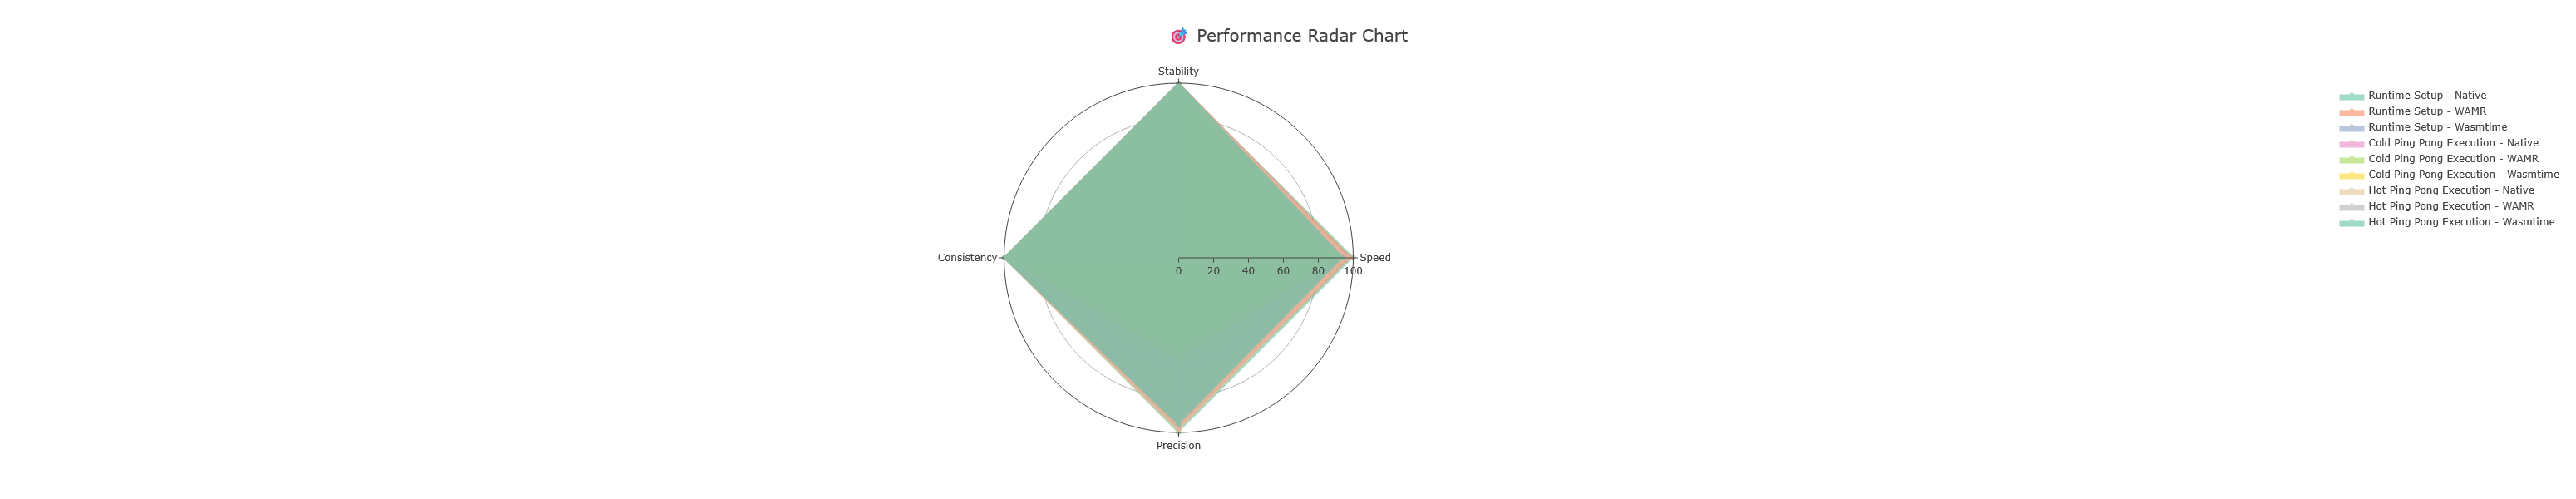

In [10]:
analyzer.plot_performance_radar()

In [11]:
# analyzer.export_all_plots("my_results")